# 5주차 실습: YOLOv8을 이용한 객체 탐지 (Object Detection)

- **학습 목표:**
  1. 사전 훈련된(Pre-trained) YOLOv8 모델을 사용해 이미지 속 객체를 탐지할 수 있다.
  2. 공개된 데이터셋(COCO128)을 이용하여 나만의 YOLOv8 모델을 훈련시키는 전체 과정을 이해하고 실습한다.
  3. 훈련된 모델의 성능을 확인하고, 새로운 이미지에 적용해본다.

### 0. Google Colab 준비 사항

#### **(1) GPU 런타임 설정**
Colab 메뉴에서 **[런타임] > [런타임 유형 변경]**을 선택하고, 하드웨어 가속기를 **GPU**로 설정하세요. GPU를 사용하면 모델 훈련 속도가 수십 배 빨라집니다.

#### **(2) Google Drive 마운트**
훈련된 모델 가중치나 결과물을 영구적으로 저장하기 위해 자신의 Google Drive를 Colab 환경에 연결(마운트)합니다.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 필요한 Module Import 및 라이브러리 설치
먼저 실습에 필요한 `ultralytics`와 `matplotlib` 라이브러리를 설치합니다.

In [5]:
# ultralytics는 YOLOv8을 사용하기 위한 핵심 라이브러리입니다.
!pip install ultralytics matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.3 MB/s eta 0:00:00


In [16]:
''' 1. Module Import '''
import torch
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
from IPython.display import Image

# Google Drive에 프로젝트 폴더를 생성하고 경로를 지정합니다.
# 이렇게 하면 결과가 내 드라이브에 저장됩니다.
GDRIVE_PROJECT_PATH = "/content/my_yolo_project"
if not os.path.exists(GDRIVE_PROJECT_PATH):
    os.makedirs(GDRIVE_PROJECT_PATH)

### 1. 딥러닝 모델을 실행할 장비 확인 (DEVICE 설정)
GPU 사용이 가능할 경우, 훨씬 빠른 속도로 모델을 훈련시킬 수 있습니다.

In [7]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)
    print('CUDA is available. Using GPU for training.')
else:
    DEVICE = torch.device('cpu')
    print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)
    print('CUDA is not available. Using CPU for training.')

Using PyTorch version: 2.6.0+cu124  Device: cpu
CUDA is not available. Using CPU for training.


### 2. 사전 훈련된 YOLOv8 모델로 객체 탐지 체험하기
YOLOv8은 이미 방대한 데이터로 훈련이 완료된 모델을 제공합니다. 이 모델을 로드하여 아주 간단하게 객체 탐지 성능을 테스트해 보겠습니다.
- `yolov8n.pt`: 가장 작고 빠른 Nano 모델
- `yolov8s.pt`, `yolov8m.pt`, `yolov8l.pt`, `yolov8x.pt`: 순서대로 더 크고 정확한 모델

100%|██████████| 6.25M/6.25M [00:00<00:00, 85.7MB/s]


100%|██████████| 134k/134k [00:00<00:00, 9.26MB/s]


image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 467.3ms
Speed: 17.7ms preprocess, 467.3ms inference, 29.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict
예측 완료! 'yolo_test/pretrained_inference' 폴더에 결과가 저장되었습니다.


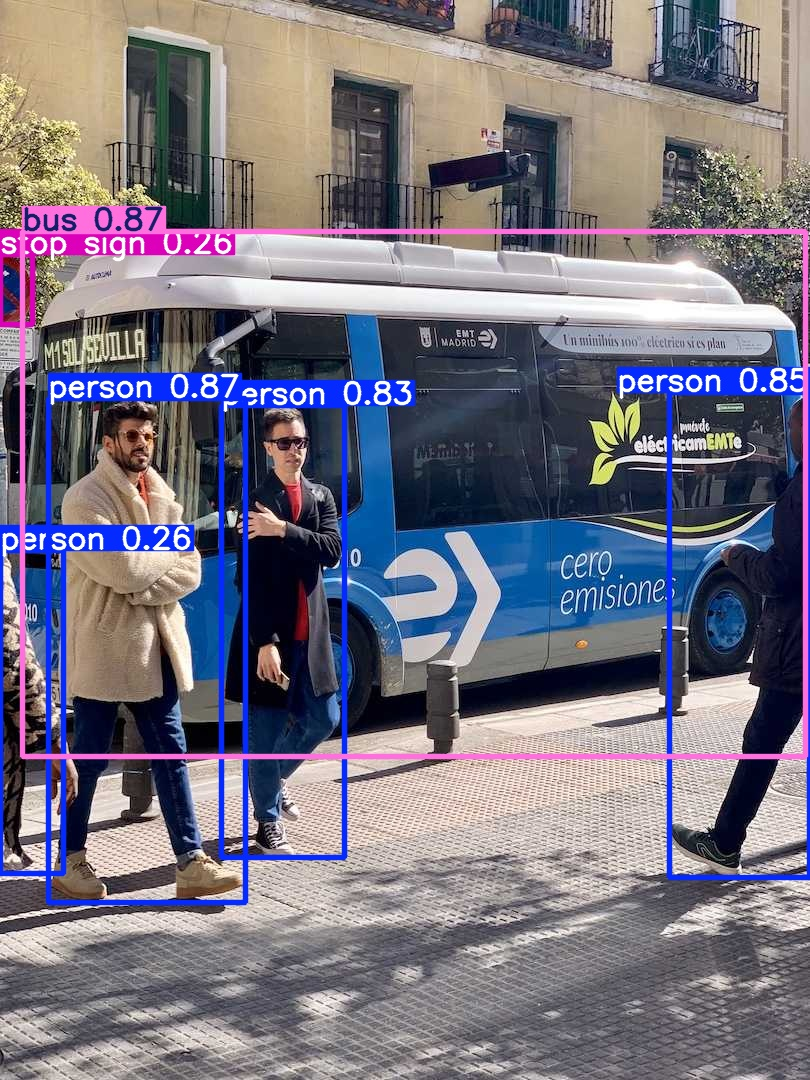

In [8]:
''' 3. 사전 훈련된 모델 로드 및 예측 '''
# 가장 기본적인 yolov8n 모델을 로드합니다.
model = YOLO('yolov8n.pt')

# 예측을 수행할 이미지 (웹 상의 이미지 주소 사용)
image_url = 'https://ultralytics.com/images/bus.jpg'

# 모델 예측 실행
# source: 이미지 파일 경로, URL, 비디오 등
# save=True: 예측 결과(바운딩 박스가 그려진 이미지)를 저장합니다.
results = model.predict(source=image_url, save=True)

print("예측 완료! 'yolo_test/pretrained_inference' 폴더에 결과가 저장되었습니다.")

# 결과 이미지 확인
# predict 함수는 runs/detect/exp 형태의 폴더에 결과를 저장합니다.
result_image_path = 'runs/detect/predict/bus.jpg'
Image(filename=result_image_path)

### 3. 나만의 객체 탐지 모델 훈련시키기
이제 라이브러리에 내장된 **COCO128 데이터셋**을 이용해 직접 모델을 훈련시켜 보겠습니다.

`ultralytics` 라이브러리는 훈련 과정을 매우 편리하게 만들어줍니다. `model.train()` 함수 하나로 데이터 로딩, 증강, 훈련 루프, 성능 평가, 모델 저장까지 모두 처리합니다.

In [9]:
''' 4. 모델 훈련 실행 '''
# 훈련을 위해 다시 yolov8n 모델 구조를 로드합니다.
# .pt 파일을 로드하면 해당 가중치에서부터 훈련을 시작합니다(전이 학습).
model = YOLO('yolov8n.pt')

# 모델 훈련 시작
# data: 훈련시킬 데이터셋의 정보가 담긴 yaml 파일. 'coco128.yaml'은 라이브러리에 내장되어 있어 바로 사용 가능합니다.
# epochs: 전체 데이터셋을 몇 번 반복하여 학습할지 설정 (실습이므로 짧게 10으로 설정)
# imgsz: 훈련에 사용할 이미지 크기
# project/name: 훈련 결과(로그, 가중치 파일 등)가 저장될 폴더 이름
results = model.train(
    data='coco128.yaml',
    epochs=10,
    imgsz=640,
    project='my_yolo_project',
    name='coco128_train_run1',
    device=DEVICE  # 위에서 확인한 장비 사용
)

engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=coco128_train_run1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=my_yolo_project, rect=False, resume=False, retina_masks=F

100%|██████████| 6.66M/6.66M [00:00<00:00, 93.5MB/s]
Unzipping /content/datasets/coco128.zip to /content/datasets/coco128...: 100%|██████████| 263/263 [00:00<00:00, 2471.43file/s]

Dataset download success ✅ (1.1s), saved to /content/datasets



100%|██████████| 755k/755k [00:00<00:00, 23.7MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

Model summary: 129 layers, 3,157,200 parameters, 3,157,184 gradients, 8.9 GFLOPs

Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1048.9±363.9 MB/s, size: 50.9 KB)


train: Scanning /content/datasets/coco128/labels/train2017... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 1300.46it/s]

train: New cache created: /content/datasets/coco128/labels/train2017.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1507.9±678.0 MB/s, size: 52.5 KB)


val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to my_yolo_project/coco128_train_run1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to my_yolo_project/coco128_train_run1
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.161       1.33      1.184         78        640: 100%|██████████| 8/8 [02:19<00:00, 17.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:46<00:00, 11.57s/it]

                   all        128        929      0.641       0.55       0.61       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.146       1.28      1.181         97        640: 100%|██████████| 8/8 [02:18<00:00, 17.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:45<00:00, 11.41s/it]

                   all        128        929      0.651      0.581      0.628      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.144      1.299      1.188        110        640: 100%|██████████| 8/8 [02:13<00:00, 16.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:43<00:00, 10.97s/it]

                   all        128        929      0.648      0.589      0.638      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.174      1.318      1.198         95        640: 100%|██████████| 8/8 [02:10<00:00, 16.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:43<00:00, 10.85s/it]

                   all        128        929      0.688      0.569      0.652      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.105      1.277      1.158         52        640: 100%|██████████| 8/8 [02:10<00:00, 16.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:44<00:00, 11.16s/it]

                   all        128        929      0.667      0.624      0.666      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.118      1.223      1.161         99        640: 100%|██████████| 8/8 [02:16<00:00, 17.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:44<00:00, 11.08s/it]

                   all        128        929      0.675      0.635      0.673      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.093      1.183      1.162        191        640: 100%|██████████| 8/8 [02:12<00:00, 16.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:46<00:00, 11.51s/it]

                   all        128        929      0.677      0.634      0.678      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.092      1.159      1.149        150        640: 100%|██████████| 8/8 [02:09<00:00, 16.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:43<00:00, 10.75s/it]

                   all        128        929       0.69      0.623       0.69      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.079       1.14       1.17        100        640: 100%|██████████| 8/8 [02:16<00:00, 17.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:44<00:00, 11.04s/it]

                   all        128        929      0.696      0.623      0.694      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G       1.08      1.098      1.148        112        640: 100%|██████████| 8/8 [02:10<00:00, 16.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:44<00:00, 11.20s/it]

                   all        128        929      0.694      0.622      0.689      0.527



10 epochs completed in 0.497 hours.
Optimizer stripped from my_yolo_project/coco128_train_run1/weights/last.pt, 6.5MB
Optimizer stripped from my_yolo_project/coco128_train_run1/weights/best.pt, 6.5MB

Validating my_yolo_project/coco128_train_run1/weights/best.pt...
Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.32s/it]


                   all        128        929      0.695      0.623      0.693      0.529
                person         61        254      0.842       0.65      0.777      0.566
               bicycle          3          6       0.92      0.333      0.361       0.32
                   car         12         46      0.697      0.239      0.321      0.195
            motorcycle          4          5      0.682      0.863      0.938       0.73
              airplane          5          6      0.801          1      0.995      0.803
                   bus          5          7      0.844      0.714      0.721      0.664
                 train          3          3      0.756          1      0.995      0.852
                 truck          5         12      0.856        0.5      0.546      0.381
                  boat          2          6      0.488      0.333      0.613      0.379
         traffic light          4         14      0.451      0.143      0.179      0.137
             stop sig

### 4. 훈련된 모델 성능 검증하기
훈련이 완료되면 `project/name`으로 지정한 폴더에 모든 결과가 저장됩니다.
- `weights/`: 훈련된 모델의 가중치 파일 (`best.pt`: 검증 성능이 가장 좋았던 모델, `last.pt`: 마지막 epoch 모델)
- `results.png`: 훈련 손실(loss), 성능(mAP) 등의 그래프
- `confusion_matrix.png`: 혼동 행렬

이 그래프들을 통해 모델이 얼마나 잘 훈련되었는지 확인할 수 있습니다.

--- 훈련 성능 그래프 ---


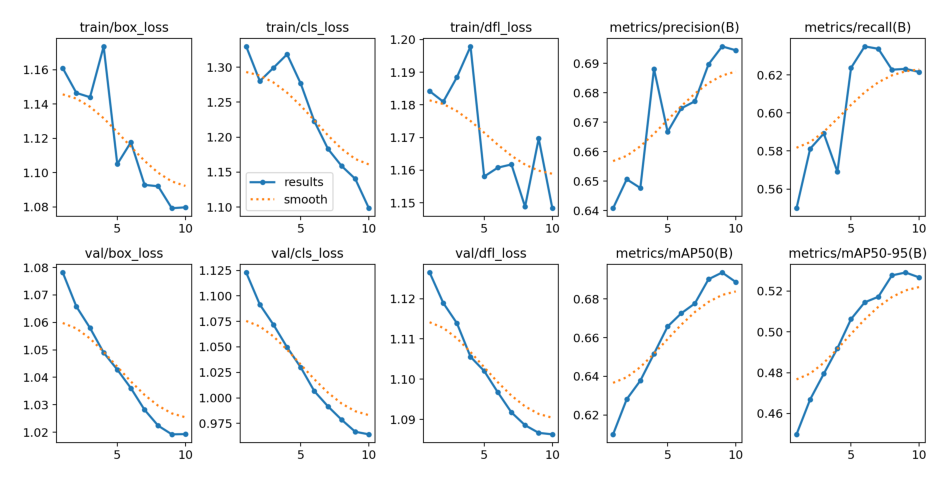

In [17]:
''' 5. 훈련 결과 그래프 확인하기 '''
# Google Drive에 저장된 결과 폴더 경로
result_dir = os.path.join(GDRIVE_PROJECT_PATH, 'coco128_train_run1')

try:
    print("--- 훈련 성능 그래프 ---")
    results_graph_path = os.path.join(result_dir, 'results.png')
    plt.figure(figsize=(12, 8))
    plt.imshow(plt.imread(results_graph_path))
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"'{results_graph_path}' 파일을 찾을 수 없습니다. Google Drive 경로를 다시 확인하거나 훈련이 정상적으로 완료되었는지 확인하세요.")

### 5. 훈련된 나만의 모델로 객체 탐지 실행하기
훈련 결과 중 가장 성능이 좋았던 `best.pt` 가중치 파일을 로드하여 새로운 모델을 만들고, 객체 탐지를 실행해 보겠습니다.

100%|██████████| 169k/169k [00:00<00:00, 947kB/s]


image 1/1 /content/000000039769.jpg: 480x640 2 cats, 1 couch, 2 remotes, 371.2ms
Speed: 7.9ms preprocess, 371.2ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/my_yolo_project/custom_model_inference


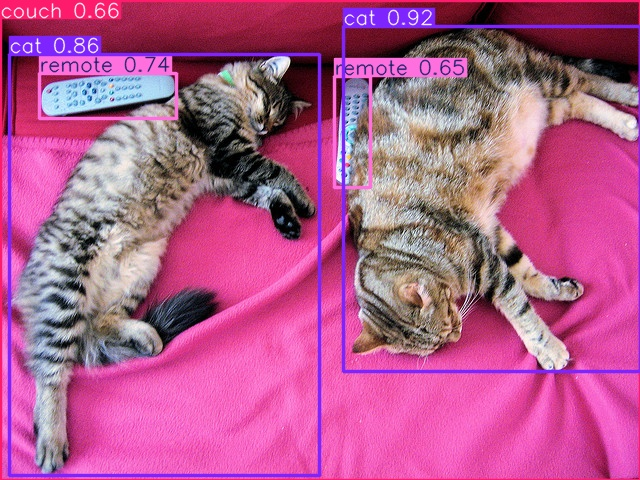

In [18]:
''' 6. 훈련된 모델로 예측 수행 '''
# Google Drive에 저장된 가장 성능이 좋았던 모델 가중치 경로
best_model_path = os.path.join(GDRIVE_PROJECT_PATH, 'coco128_train_run1', 'weights', 'best.pt')

# 훈련된 모델 로드
trained_model = YOLO(best_model_path)

# 테스트할 이미지
test_image_url = 'http://images.cocodataset.org/val2017/000000039769.jpg' # 고양이와 리모컨 이미지

# 예측 실행 (결과도 Drive에 저장)
trained_model.predict(
    source=test_image_url,
    save=True,
    project=GDRIVE_PROJECT_PATH,
    name='custom_model_inference'
)

# 결과 이미지 확인
custom_result_image_path = os.path.join(GDRIVE_PROJECT_PATH, 'custom_model_inference', '000000039769.jpg')
Image(filename=custom_result_image_path)